# Module 17: K-Nearest Neighbour (KNN)  

This notebook covers the following sections for **KNN Classification**:
1. **Training & Prediction Process**
2. **Implementing KNN on a Dataset**
3. **Model Evaluation & Optimization**


## 0) Setup
We will use:
- `StandardScaler` because KNN depends on distances
- `KNeighborsClassifier` for classification
- A clean sklearn `Pipeline` to learn the correct workflow


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report
)

np.random.seed(42)


# 1) Training & Prediction Process (sklearn view)

### What “training” means for KNN
KNN is called a **lazy learner** because it does not learn weights or coefficients.

In practice, `.fit()` does two important things:
- Fits the scaler on training data (learns mean and standard deviation)
- Stores the training examples inside the KNN model

So training is fast, but prediction can be expensive.

### What prediction means
During `.predict()` KNN does:
1. Compute distance from the query point to all stored training points  
2. Sort distances  
3. Select the K nearest neighbors  
4. Majority vote for the predicted class  

That is why KNN can become slow when the dataset is large.


## Why scaling is non-negotiable
KNN uses distance. Distance is scale-sensitive.

If one feature has a much larger range than others, it dominates distance and breaks neighbor selection.
So we always place `StandardScaler` before KNN in the pipeline.


# 2) Implementing KNN on a Dataset

We use the **Wine dataset** (3 classes). It is good for learning because:
- All features are numeric
- Multi-class classification feels realistic
- Scaling matters

Pipeline we follow:
1. Train-test split  
2. Pipeline = scaling + KNN  
3. Fit on training data  
4. Predict on test data  
5. Evaluate  


In [2]:
wine = load_wine()
X = wine.data
y = wine.target

print("Dataset shape:", X.shape)
print("Classes:", list(wine.target_names))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


Dataset shape: (178, 13)
Classes: [np.str_('class_0'), np.str_('class_1'), np.str_('class_2')]


In [3]:
# Baseline KNN model (Euclidean distance via Minkowski p=2)
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=15, metric="minkowski", p=2))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print("Accuracy:", float(accuracy_score(y_test, y_pred)))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=wine.target_names))

Accuracy: 1.0

Confusion Matrix:
 [[15  0  0]
 [ 0 18  0]
 [ 0  0 12]]

Classification Report:
               precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        15
     class_1       1.00      1.00      1.00        18
     class_2       1.00      1.00      1.00        12

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



## Key KNN parameters one must know

- `n_neighbors` (K): number of neighbors consulted  
- `metric`: how distance is computed  
- `p` (for Minkowski):  
  - p = 2 means Euclidean  
  - p = 1 means Manhattan  
- `weights`:  
  - `uniform`: all neighbors vote equally  
  - `distance`: closer neighbors vote more  


# 3) Model Evaluation & Optimization

We will tune K by trying a range of values and plotting accuracy.

Note:
- This uses the test split for a simple classroom demo.
- In serious ML work, use cross-validation.


In [4]:
#We will tune K by trying a range of values and plotting accuracy.
k_values = range(1,42)
accs = []

for k in k_values:
  model = Pipeline([
      ("scaler", StandardScaler()),
      ("knn", KNeighborsClassifier(n_neighbors=k))
  ])
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  accs.append(accuracy_score(y_test, pred))

In [5]:
print(accs)

[0.9555555555555556, 0.9333333333333333, 0.9555555555555556, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9777777777777777, 0.9555555555555556, 0.9777777777777777, 0.9777777777777777, 0.9777777777777777, 0.9777777777777777, 0.9777777777777777, 0.9777777777777777, 1.0, 0.9777777777777777, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9777777777777777, 0.9777777777777777, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9777777777777777, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9111111111111111, 0.9333333333333333, 0.9111111111111111, 0.9111111111111111, 0.9111111111111111, 0.9555555555555556, 0.9111111111111111, 0.9333333333333333]


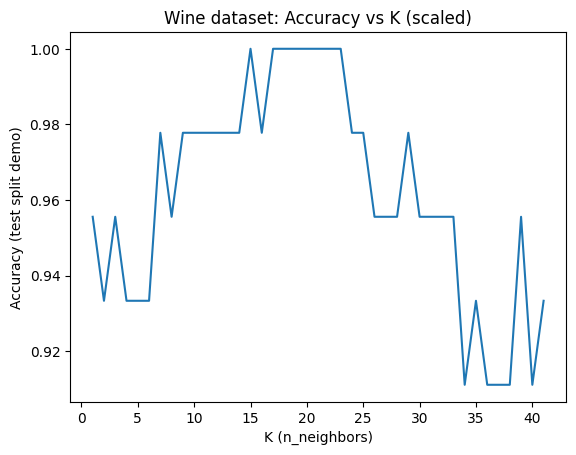

Best K (by this demo): 15
Best accuracy: 1.0


In [6]:
plt.figure()
plt.plot(list(k_values), accs)
plt.xlabel("K (n_neighbors)")
plt.ylabel("Accuracy (test split demo)")
plt.title("Wine dataset: Accuracy vs K (scaled)")
plt.show()

best_k = list(k_values)[int(np.argmax(accs))]
print("Best K (by this demo):", best_k)
print("Best accuracy:", float(np.max(accs)))

## Compare distance metrics and voting weights

We compare:
- Euclidean distance (p=2)
- Manhattan distance (p=1)
- Euclidean with distance-weighted voting

Goal: Show that KNN is not “one model”. Its behavior depends on your choices.


In [ ]:
#Compare distance metrics and voting weights
k_demo = best_k

settings = [
    ("Euclidean (p=2), uniform", KNeighborsClassifier(n_neighbors=k_demo, metric="minkowski",p=2,weights="uniform")),
    ("Manhattan (p=1), uniform", KNeighborsClassifier(n_neighbors=k_demo, metric="minkowski",p=1,weights="uniform")),
    ("Euclidean (p=2), distance", KNeighborsClassifier(n_neighbors=k_demo, metric="minkowski",p=2,weights="distance")),
]

rows = []
for name,knn in settings:
  model = Pipeline([("scaler", StandardScaler()), ("knn",knn)])
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  rows.append([name, accuracy_score(y_test,pred)])

pd.DataFrame(rows, columns=["Setting", "Accuracy"]).sort_values("Accuracy", ascending=False)

,Setting,Accuracy
0,"Euclidean (p=2), uniform",1.000000
2,"Euclidean (p=2), distance",1.000000
1,"Manhattan (p=1), uniform",0.977778


## Optional: What changes if you forget scaling?

This cell trains KNN **without scaling** and compares accuracy.


In [ ]:
# KNN without scaling (intentionally)
knn_no_scale = KNeighborsClassifier(n_neighbors=best_k)
knn_no_scale.fit(X_train, y_train)
pred_no_scale = knn_no_scale.predict(X_test)

acc_no_scale = accuracy_score(y_test, pred_no_scale)

# KNN with scaling (pipeline)
pred_scaled = clf.predict(X_test)
acc_scaled = accuracy_score(y_test, pred_scaled)

print("Accuracy without scaling:", float(acc_no_scale))
print("Accuracy with scaling:", float(acc_scaled))


Accuracy without scaling: 0.7777777777777778
Accuracy with scaling: 0.9777777777777777


# 4) Final Summary

### Training & Prediction Process
- `.fit()` stores training data and fits scaler (if used)
- `.predict()` computes distances and votes

### Implementation
- Use a pipeline: `StandardScaler` then `KNeighborsClassifier`
- Split before scaling. Fit scaler on train only.

### Evaluation & Optimization
- Accuracy, confusion matrix, classification report
- Tune K using a curve (and ideally cross-validation)
- Compare metrics and weights

One line you should remember:
**KNN is a distance machine. If distances are wrong, predictions are wrong.**
